In [2]:
#imports
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
#from torchinfo import summary
#import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm import tqdm

import cv2
from PIL import Image

from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# loading data

## variables

In [3]:
N_max=282
#use_patches=True

In [4]:
transform_resnet18 = transforms.Compose([
    transforms.Resize(256,interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize(mean=[0.9672, 0.9702, 0.9829], std=[0.1065, 0.0999, 0.0656])
    #transforms.Pad((0, 0, 0, 0), fill=0, padding_mode="constant"),  # Optional: Add padding if needed
    #weights["efficient"].transforms()
])

In [5]:
# ------------------------------
# Data Augmentation for Contrastive Learning
# ------------------------------
color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)

ContrastiveTransform = transforms.Compose([
    #transforms.Resize(256,interpolation=InterpolationMode.BILINEAR),
    #transforms.CenterCrop(256),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomApply([color_jitter], p=0.8),
    #transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Normalize(mean=[0.9672, 0.9702, 0.9829], std=[0.1065, 0.0999, 0.0656])
])

## functions

In [6]:
def extract_patches(image,gw=5,n_cc=10):
    """Splits image into grid patches and checks for text presence."""
    image_gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    h, w = image_gray.shape
    patch_w = w // gw
    patch_h = patch_w
    gh= h // patch_h
    
    valid_patches = []
    
    for i in range(gh):
        for j in range(gw):
            x1, y1 = j * patch_w, i * patch_h
            x2, y2 = x1 + patch_w, y1 + patch_h
            patch = image_gray[y1:y2, x1:x2]
            
            # Check for text using connected components
            _, binary = cv2.threshold(patch, 180, 255, cv2.THRESH_BINARY_INV)
            num_labels, _, _, _ = cv2.connectedComponentsWithStats(binary)
            
            if num_labels > n_cc:  # More than 1 means text is present
                #patch_rgb = image.crop((x1, y1, x2, y2))  # Extract RGB patch
                valid_patches.append((x1, y1, x2, y2,num_labels))
    
    return valid_patches

In [7]:
def process_row(row):
    image = Image.open(row["file_name"])  # Open the image
    #print(row["file_name"])
    patches = extract_patches(image,gw=5,n_cc=10)  # Extract patches
    
    # Create a new row for each patch
    new_rows = []
    for (x, y, x2, y2,n_cc) in patches:
        new_row = row.copy()
        new_row["x"], new_row["y"], new_row["x2"], new_row["y2"],new_row["n_cc"] = x, y, x2, y2, n_cc
        new_rows.append(new_row)
    
    return new_rows

In [8]:
# Function to show a batch of images
def show_images(images, writers, labels, save_path=None):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for img, ax, writer, label in zip(images, axes, writers, labels):
        img = img.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
        ax.imshow(img)
        ax.set_title(str(int(writer))+'_'+str(int(label)))
        ax.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [9]:
# Function to show a single image
def show_single_image(image, writer, label, save_path=None):
    img = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
    plt.imshow(img)
    plt.title(f'Writer: {writer}, Label: {label}')
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [10]:
class CustomPatchDataset(Dataset):
    def __init__(self, df, label_column,transform=ContrastiveTransform):
        """
        Args:
            image_dirs (list of str): List of directories to load images from.
            labels_df (DataFrame): DataFrame containing labeled images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = df['file_name'].tolist()
        self.img_labels = df[label_column].tolist()
        self.img_writers = df['writer'].tolist()
        self.x1 = df['x'].tolist()
        self.y1 = df['y'].tolist()
        self.x2 = df['x2'].tolist()
        self.y2 = df['y2'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        x1=self.x1[idx]
        y1=self.y1[idx]
        x2=self.x2[idx]
        y2=self.y2[idx]
        image = Image.open(img_path).convert("RGB")
        patch = image.crop((x1, y1, x2, y2))
        writer=self.img_writers[idx]
        label = self.img_labels[idx]

        if self.transform:
            patch1 = self.transform(patch)
            patch2 = self.transform(patch)

        return {
            'image1': patch1,
            'image2': patch2,
            'writer': int(writer),
            'label': label
        }

In [11]:
class CustomPatchDataset_2(Dataset):
    def __init__(self, df, label_column,transform=ContrastiveTransform):
        """
        Args:
            image_dirs (list of str): List of directories to load images from.
            labels_df (DataFrame): DataFrame containing labeled images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = df['file_name'].tolist()
        self.img_labels = df[label_column].tolist()
        self.img_writers = df['writer'].tolist()
        self.x1 = df['x'].tolist()
        self.y1 = df['y'].tolist()
        self.x2 = df['x2'].tolist()
        self.y2 = df['y2'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        x1=self.x1[idx]
        y1=self.y1[idx]
        x2=self.x2[idx]
        y2=self.y2[idx]
        image = Image.open(img_path).convert("RGB")
        patch = image.crop((x1, y1, x2, y2))
        writer=self.img_writers[idx]
        label = self.img_labels[idx]

        if self.transform:
            patch = self.transform(patch)

        return {
            'image': patch,
            'writer': int(writer),
            'label': label
        }

## code

In [12]:
data_PATH="D:\\download\\PD project\\datasets\\ICDAR 2013 - Gender Identification Competition Dataset"
image_PATH=data_PATH+"\\unzipped"
models_path=".\outputs\models"
train_df_complete = pd.read_csv(os.path.join(data_PATH, "train\\train.csv"))

In [46]:
sex_df = pd.read_csv(os.path.join(data_PATH, "train_answers.csv"),delimiter=',')

In [47]:
# Get the counts of each unique value in the "male" column
male_counts = sex_df['male'].value_counts(dropna=False)

# Print the counts
print("Number of times 'male' is 0:", male_counts.get(0, 0))
print("Number of times 'male' is 1:", male_counts.get(1, 0))
print("Number of times 'male' is something else:", len(sex_df) - male_counts.get(0, 0) - male_counts.get(1, 0))

Number of times 'male' is 0: 143
Number of times 'male' is 1: 139
Number of times 'male' is something else: 0


In [48]:
selected_columns = ['writer', 'language', 'same_text']
train_df = train_df_complete[selected_columns]

# Convert the 'language' column to binary columns
language_dummies = pd.get_dummies(train_df['language'], drop_first=True)

# Add the binary column to the dataframe
train_df['isEng'] = language_dummies.iloc[:, 0].astype(int)

# Drop the original 'language' column
train_df.drop(columns=['language'], inplace=True)

# Display the updated dataframe
train_df.head(10)

C:\Users\burtm\AppData\Local\Temp\ipykernel_24404\4054552359.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['isEng'] = language_dummies.iloc[:, 0].astype(int)
C:\Users\burtm\AppData\Local\Temp\ipykernel_24404\4054552359.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['language'], inplace=True)


,writer,same_text,isEng
0,1,0,0
1,1,1,0
2,1,0,1
3,1,1,1
4,2,0,0
5,2,1,0
6,2,0,1
7,2,1,1
8,3,0,0
9,3,1,0


In [49]:
# Set the probability of being 0
p_train = 0.9
N=282

# Create a dataframe with writer column from 1 to 282
writers_df = pd.DataFrame({'writer': np.arange(1, N+1)})

# Add a train column that is randomly 0 or 1 with probability p of being 0
writers_df['train'] = np.random.choice([0, 1], size=len(writers_df), p=[1-p_train, p_train])

# Merge with the train_df dataframe on the writer column
train_df = train_df.merge(writers_df, on='writer', how='left')

# Display the dataframe
train_df.head()

,writer,same_text,isEng,train
0,1,0,0,1
1,1,1,0,1
2,1,0,1,1
3,1,1,1,1
4,2,0,0,1


In [50]:
folder_names = [folder for folder in os.listdir(image_PATH) if os.path.isdir(os.path.join(image_PATH, folder))]
# Extract the X part from the folder names
x_values = [int(folder.split('_')[0]) for folder in folder_names]

# Sort both lists based on the X values
sorted_indices = sorted(range(len(x_values)), key=lambda k: x_values[k])
folder_names = [folder_names[i] for i in sorted_indices]
x_values = [x_values[i] for i in sorted_indices]
print(folder_names)

['1_50', '51_100', '101_150', '151_200', '201_250', '251_300']


In [51]:
# Loop through each directory and collect image file paths for labeled images only
image_dirs = [os.path.join(image_PATH, folder) for folder in folder_names]
writers = []
isEng = []
same_text = []
file_names = []

for image_dir in image_dirs:
    for f in os.listdir(image_dir):
        if f.endswith('.jpg'):
            base_name = os.path.splitext(f)[0]  # Remove extension
            parts = base_name.split('_')

            if len(parts) != 2:
                continue  # Skip files that don't follow the expected pattern

            index, version = parts

            if int(version)>2:
                isEng.append(1)
            else:
                isEng.append(0)
            if int(version)%2==0:
                same_text.append(1)
            else:
                same_text.append(0)
            file_names.append(os.path.join(image_dir,f))
            writers.append(int(index))

# Create a dataframe from the extracted index and version values
train_file_df = pd.DataFrame({'writer': writers, 'isEng': isEng, 'same_text': same_text,'file_name':file_names})

# Display the dataframe
print(train_file_df['writer'].nunique())


300


In [52]:
# Merge the file_name column to the train_df dataframe based on the writer column
train_df = train_df.merge(train_file_df, on=['isEng','writer','same_text'], how='left')

# Display the updated dataframe
train_df.head(10)

,writer,same_text,isEng,train,file_name
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
1,1,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
2,1,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
3,1,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
4,2,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
5,2,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
6,2,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
7,2,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...
8,3,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...
9,3,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...


In [53]:
# Merge the file_name column to the train_df dataframe based on the writer column
train_df = train_df.merge(sex_df, on=['writer'], how='left')

# Display the updated dataframe
train_df.head(10)

,writer,same_text,isEng,train,file_name,male
0,1,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
1,1,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
2,1,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
3,1,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
4,2,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
5,2,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
6,2,0,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
7,2,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
8,3,0,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0
9,3,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0


In [13]:
# Define the file path
file_path = "..\\Data\\train_df_expanded.csv" #cause the . directory is the notebooks folder

# Check if the file exists, if not, save the DataFrame
if not os.path.exists(file_path):
    #process_row(train_df.iloc[0])
    # Apply function to each row and explode the list
    train_df_expanded = pd.DataFrame(sum(train_df.apply(process_row, axis=1), []))
    #train_df_expanded.head()
    train_df_expanded.to_csv(file_path, index=False)
    print(f"File saved: {file_path}")
else:
    print(f"File already exists: {file_path}")
    train_df_expanded = pd.read_csv(file_path)

#i select the m patches per writer that have the highest number of cc
m=10
train_df_expanded_sorted = train_df_expanded.sort_values(by='n_cc', ascending=False)
train_df_expanded = train_df_expanded_sorted.groupby('writer').head(m)

File already exists: ..\Data\train_df_expanded.csv


## datasets and dataloaders

In [26]:
train_dataset = CustomPatchDataset(train_df_expanded[(train_df_expanded['train']==1) & (train_df_expanded['writer']<=N_max)] ,
                                label_column='male', transform=ContrastiveTransform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CustomPatchDataset(train_df_expanded[(train_df_expanded['train']==0) & (train_df_expanded['writer']<=N_max)] ,
                                label_column='male', transform=ContrastiveTransform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [27]:
train_dataset_2 = CustomPatchDataset_2(train_df_expanded[(train_df_expanded['train']==1) & (train_df_expanded['writer']<=N_max)] ,
                                label_column='male', transform=transform_resnet18)
train_dataloader_2 = DataLoader(train_dataset_2, batch_size=16, shuffle=True)

val_dataset_2 = CustomPatchDataset_2(train_df_expanded[(train_df_expanded['train']==0) & (train_df_expanded['writer']<=N_max)] ,
                                label_column='male', transform=transform_resnet18)
val_dataloader_2 = DataLoader(val_dataset_2, batch_size=16, shuffle=True)

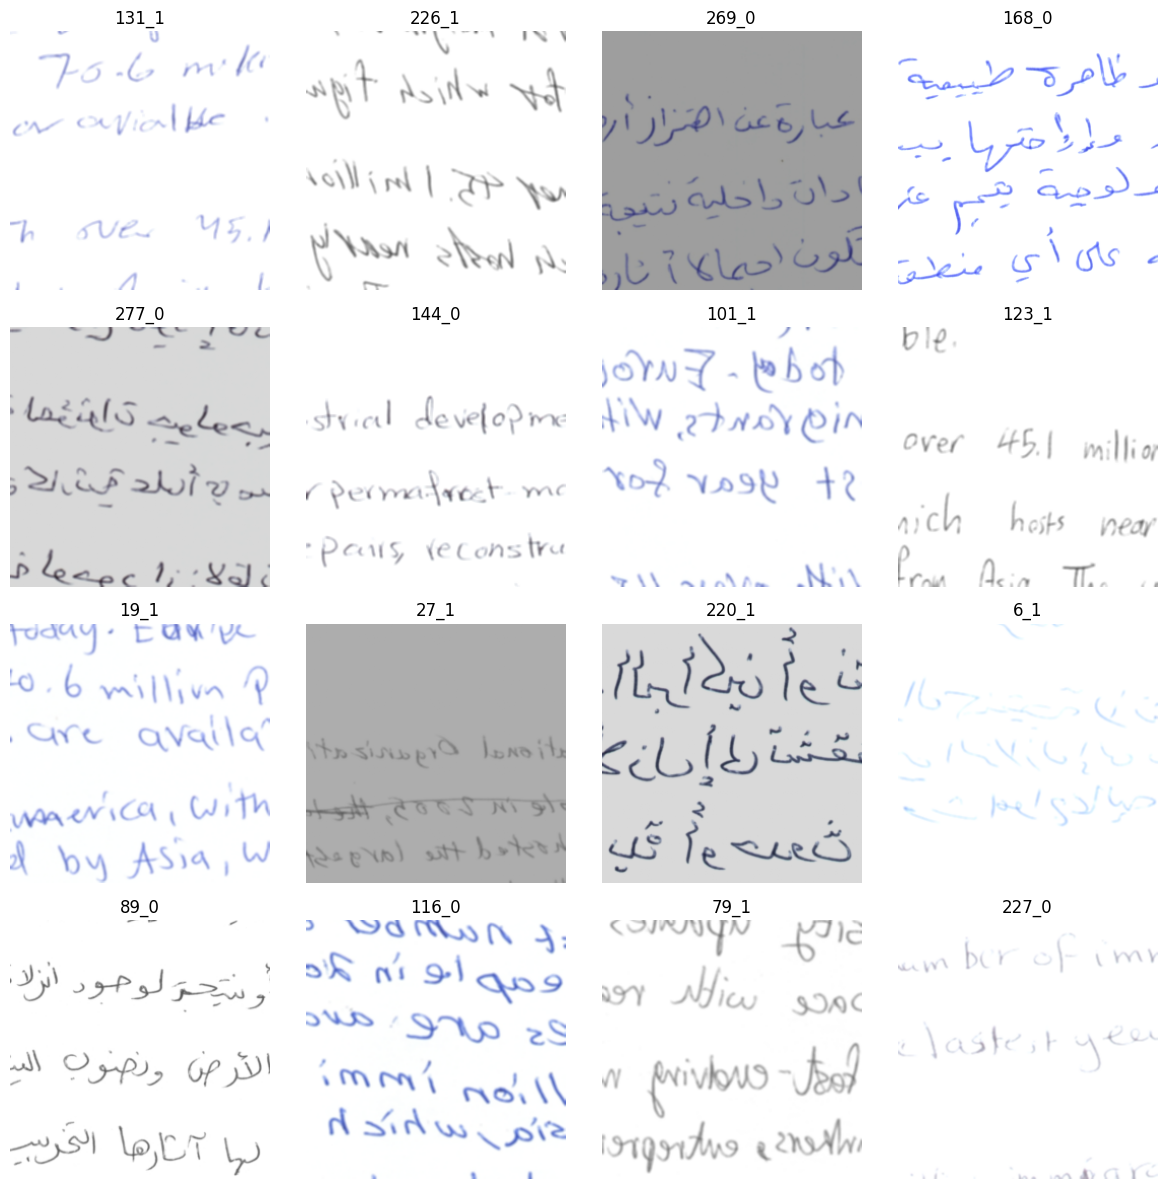

In [ ]:
# Create an iterator
data_iter = iter(train_dataloader)
# Get a single batch
batch = next(data_iter)
show_images(batch['image1'], batch['writer'], batch['label'], save_path='..\outputs\images\contrastive_preprocessed_images.jpg')

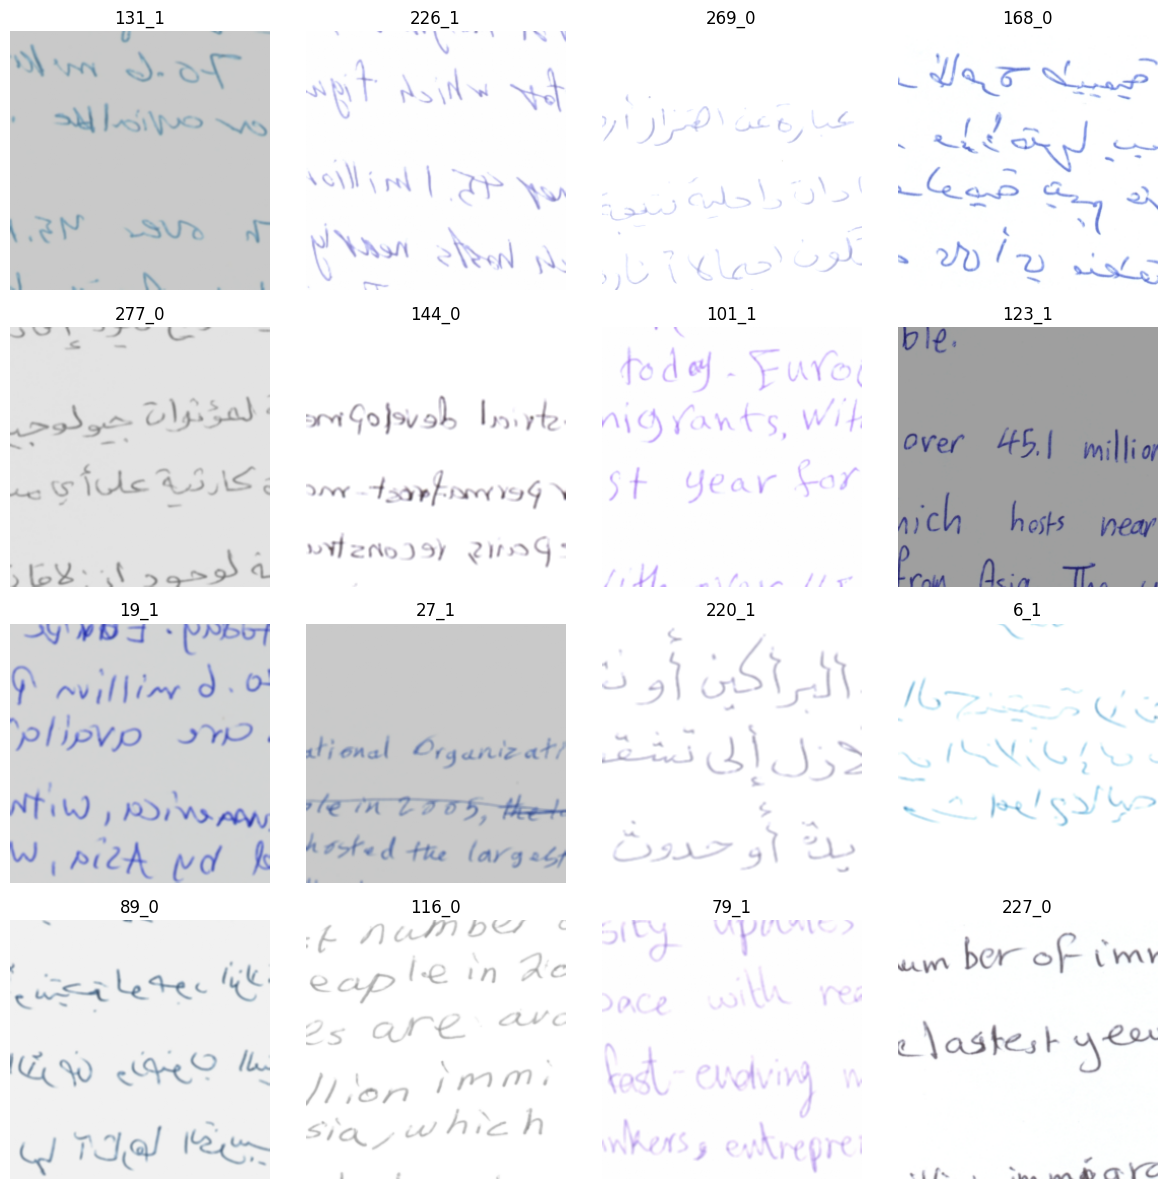

In [89]:
show_images(batch['image2'], batch['writer'], batch['label'], save_path='..\outputs\images\\augm_contrastive_preprocessed_images.jpg')

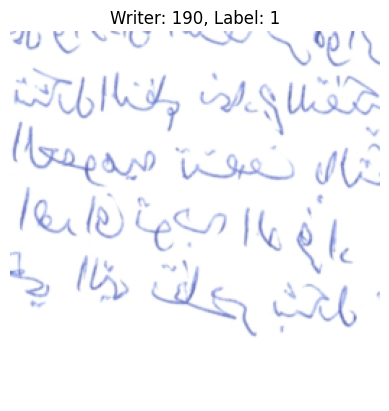

In [16]:
# Specify the index of the image you want to show
index = 0  # Change this to the index of the image you want to display

# Extract the image, writer, and label from the dataset
sample = train_dataset[index]
image = sample['image1']
writer = sample['writer']
label = sample['label']

# Show the single image
show_single_image(image, writer, label,save_path='..\outputs\images\contrastive_writer_0_preprocessed.jpg')

In [92]:
print(image.shape)  # Print the shape of the image tensor
# Assuming `image` is a tensor with shape (C, H, W)
min_values = torch.amin(image, dim=(1, 2))  # Min value for each channel
max_values = torch.amax(image, dim=(1, 2))  # Max value for each channel
avg_values = torch.mean(image, dim=(1, 2))       # Average value for each channel

print("Min values for each channel:", min_values)
print("Max values for each channel:", max_values)
print("Average values for each channel:", avg_values)

torch.Size([3, 256, 256])
Min values for each channel: tensor([0.3647, 0.3961, 0.6667])
Max values for each channel: tensor([1., 1., 1.])
Average values for each channel: tensor([0.9648, 0.9690, 0.9869])


In [74]:
shape = image.shape  # OR tensor.size()
mean_dim0 = torch.mean(image, dim=0)  # Compute mean along rows (axis 0)
min_dim0, min_indices = torch.min(image, dim=0)  # Min values along axis 0
max_dim0, max_indices = torch.max(image, dim=0)  # Max values along axis 0
print(shape)
print(mean_dim0.shape)  # Shape of the mean tensor
print(min_dim0.shape)  # Shape of the min tensor
print(max_dim0.shape)  # Shape of the max tensor


torch.Size([3, 256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


In [93]:
'''def compute_mean_std(dataloader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    for batch in dataloader:
        images = batch['image1']  # Assuming 'image1' contains the images
        batch_size, channels, height, width = images.shape
        total_images += batch_size

        # Compute mean and std for the batch
        mean += images.mean(dim=[0, 2, 3]) * batch_size
        std += images.std(dim=[0, 2, 3]) * batch_size

    mean /= total_images
    std /= total_images

    return mean, std

mean, std = compute_mean_std(train_dataloader)
print("Mean:", mean)
print("Std:", std)'''

'def compute_mean_std(dataloader):\n    mean = torch.zeros(3)\n    std = torch.zeros(3)\n    total_images = 0\n\n    for batch in dataloader:\n        images = batch[\'image1\']  # Assuming \'image1\' contains the images\n        batch_size, channels, height, width = images.shape\n        total_images += batch_size\n\n        # Compute mean and std for the batch\n        mean += images.mean(dim=[0, 2, 3]) * batch_size\n        std += images.std(dim=[0, 2, 3]) * batch_size\n\n    mean /= total_images\n    std /= total_images\n\n    return mean, std\n\nmean, std = compute_mean_std(train_dataloader)\nprint("Mean:", mean)\nprint("Std:", std)'

# Model initialization

## functions

In [17]:
# ------------------------------
# Contrastive Pretraining (SimCLR)
# ------------------------------
class ContrastiveModel(nn.Module):
    """ResNet Backbone + Projection Head for SimCLR."""
    def __init__(self, model, projection_dim=128):
        super().__init__()
        self.encoder = model
        self.encoder.fc = nn.Identity()  # Remove the classification head
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return F.normalize(projections, dim=1)

## code

In [18]:
selected_model = "resnet18"

In [28]:
resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [29]:
print(resnet18_model)
#it has 512 out features for the penultimate layer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
contrastive_model = ContrastiveModel(resnet18(weights=ResNet18_Weights.DEFAULT), projection_dim=128)

In [13]:
print(contrastive_model)

ContrastiveModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [31]:
classification_model = resnet18_model
classification_model.fc = nn.Linear(512, 2)  # Adapt to binary classification

# Training

## functions

In [23]:
# ------------------------------
# NT-Xent Contrastive Loss
# ------------------------------
class NTXentLoss(nn.Module):
    """Normalized Temperature-scaled Cross Entropy Loss (SimCLR)."""
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z = torch.cat([z_i, z_j], dim=0)  # Stack positive pairs
        #print("stacked: ",z.shape)
        #print(z)
        similarity_matrix = torch.matmul(z, z.T)  # Cosine similarity
        #I don't normalize because the model already does it in the forward pass
        #print("similarity_matrix: ",similarity_matrix.shape)
        #print(similarity_matrix)
        
        # Remove self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)
        #print("similarity_matrix: ",similarity_matrix.shape)
        #print(similarity_matrix)
        
        # Compute positive pairs similarity
        '''
        positives = torch.cat([torch.diag(similarity_matrix, batch_size-1), 
                               torch.diag(similarity_matrix, -batch_size+1)], dim=0)
        '''
        
        # Compute NT-Xent loss
        #labels = torch.arange(2 * batch_size, device=z.device)
        labels = torch.cat([torch.arange(batch_size-1,2*batch_size-1, device=z.device),
                            torch.arange(batch_size, device=z.device)], dim=0)
        #print("labels: ",labels.shape)
        #print(labels)
        
        # Each row should have the highest score at its label index to be used by the crossentropy loss
        loss = self.criterion(similarity_matrix / self.temperature, labels)
        #labels should be the class indexes. The first argument are the logits.
        return loss

# ------------------------------
# Step 1: Contrastive Pretraining
# ------------------------------
def pretrain_contrastive(model, dataloader, optimizer, device, epochs=10):
    model.train()
    loss_fn = NTXentLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x_i, x_j = batch['image1'], batch['image2']
            x_i, x_j = x_i.to(device), x_j.to(device)
            z_i, z_j = model(x_i), model(x_j)
            loss = loss_fn(z_i, z_j)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")



In [24]:
#helper functions and classes for this section
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                device, num_epochs=5, checkpoint_path=None,early_stopping_patience=10, use_scheduler=False):
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        # Training Loop
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = batch['image'], batch['label']
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = correct / total
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Validation Loop
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch['image'], batch['label']
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = correct / total
        print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save checkpoint if loss improves
        if checkpoint_path and avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_loss
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break
        if use_scheduler:
            scheduler.step()
    
    return model, train_losses, val_losses

def progressive_unfreezing(model,model_name, train_loader,val_loader, 
                           criterion, device, base_lr=1e-3, num_epochs_per_stage=2):
    all_train_losses, all_val_losses = [], []
    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False
    if model_name=='resnet18':
        for param in model.fc.parameters(): #for resnet the last concolutional layer is called fc
            param.requires_grad = True
        # Define optimizer for the classifier only
        optimizer = optim.Adam(model.fc.parameters(), lr=base_lr)
        layer_groups = [model.layer4, model.layer3, model.layer2, model.layer1]  # Deepest to shallowest layers
    else:
        print('model not supported')
        return
    
    print('Step 1: training classification head')
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, 
                                                  optimizer, device, num_epochs=num_epochs_per_stage,
                                                  checkpoint_path='../checkpoints/classifier.pth')
    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)
    print('model on:',next(model.parameters()).device)

    # **Step 2: Unfreeze layers progressively**
    print('Step 2: Unfreeze layers progressively')
    lr = base_lr * 0.1  # Reduce learning rate for deeper layers

    for i,layer in enumerate(layer_groups):
        # Unfreeze the current layer
        for param in layer.parameters():
            param.requires_grad = True  

        # Define new optimizer with unfrozen layers
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Train again with the newly unfrozen layer
        print(f"\nUnfreezing layer {i} and training...")
        model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, 
                                                      optimizer, device, num_epochs=num_epochs_per_stage,
                                                      checkpoint_path=f'../checkpoints/fine_tuning_layer_{i}.pth')
        all_train_losses.extend(train_losses)
        all_val_losses.extend(val_losses)
        print('model on:',next(model.parameters()).device)
        # Decrease learning rate for stability
        lr *= 0.1  
    print('fine tuning complete')
    return model, all_train_losses, all_val_losses

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.show()


## radom test

In [21]:
class RandomTensorDataset(Dataset):
    def __init__(self, num_samples, image_size=(256, 256, 3)):
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        tensor1 = torch.rand(*self.image_size).permute(2, 0, 1)  # Convert to (C, H, W)
        #tensor2 = torch.rand(*self.image_size).permute(2, 0, 1)  # Convert to (C, H, W)
        tensor2 = tensor1.clone()
        return tensor1, tensor2

# Create the dataset and dataloader
random_dataset = RandomTensorDataset(num_samples=1000)
random_dataloader = DataLoader(random_dataset, batch_size=3, shuffle=True)

# Example: Fetch a batch
random_batch = next(iter(random_dataloader))
print(f"Batch tensor1 shape: {random_batch[0].shape}")
print(f"Batch tensor2 shape: {random_batch[1].shape}")

Batch tensor1 shape: torch.Size([3, 3, 256, 256])
Batch tensor2 shape: torch.Size([3, 3, 256, 256])


In [22]:
x_i,x_j = random_batch[0],random_batch[1]
z_i, z_j = contrastive_model(x_i), contrastive_model(x_j)
print(f"Batch representation1 shape: {z_i.shape}")
print(f"Batch representation2 shape: {z_j.shape}")

Batch representation1 shape: torch.Size([3, 10])
Batch representation2 shape: torch.Size([3, 10])


In [18]:
print(z_i[0]-z_j[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SubBackward0>)


In [34]:
loss_fn = NTXentLoss()
loss = loss_fn(z_i, z_j)

stacked:  torch.Size([6, 10])
tensor([[-0.3102,  0.0861,  0.0577,  0.2929, -0.6085, -0.2531,  0.1815, -0.3245,
         -0.1531,  0.4597],
        [ 0.1333, -0.0379,  0.1585, -0.1918, -0.4724,  0.0645,  0.3494, -0.3464,
         -0.4000,  0.5380],
        [-0.2865, -0.0284,  0.3475, -0.2848, -0.5702, -0.1441,  0.1548, -0.4361,
         -0.2580,  0.2976],
        [-0.3102,  0.0861,  0.0577,  0.2929, -0.6085, -0.2531,  0.1815, -0.3245,
         -0.1531,  0.4597],
        [ 0.1333, -0.0379,  0.1585, -0.1918, -0.4724,  0.0645,  0.3494, -0.3464,
         -0.4000,  0.5380],
        [-0.2865, -0.0284,  0.3475, -0.2848, -0.5702, -0.1441,  0.1548, -0.4361,
         -0.2580,  0.2976]], grad_fn=<CatBackward0>)
similarity_matrix:  torch.Size([6, 6])
tensor([[1.0000, 0.6639, 0.7524, 1.0000, 0.6639, 0.7524],
        [0.6639, 1.0000, 0.8012, 0.6639, 1.0000, 0.8012],
        [0.7524, 0.8012, 1.0000, 0.7524, 0.8012, 1.0000],
        [1.0000, 0.6639, 0.7524, 1.0000, 0.6639, 0.7524],
        [0.6639, 1.0

## code

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

contrastive_model = contrastive_model.to(device)
optimizer = optim.Adam(contrastive_model.parameters(), lr=1e-3)
pretrain_contrastive(contrastive_model, train_dataloader, optimizer, device, epochs=20)

Epoch 1/20: 100%|██████████| 42/42 [17:38<00:00, 25.20s/it]


Epoch [1/20], Loss: 3.3796


Epoch 2/20: 100%|██████████| 42/42 [17:01<00:00, 24.32s/it]


Epoch [2/20], Loss: 3.1368


Epoch 3/20: 100%|██████████| 42/42 [16:27<00:00, 23.51s/it]


Epoch [3/20], Loss: 3.0945


Epoch 4/20: 100%|██████████| 42/42 [16:24<00:00, 23.44s/it]


Epoch [4/20], Loss: 3.0707


Epoch 5/20: 100%|██████████| 42/42 [16:28<00:00, 23.53s/it]


Epoch [5/20], Loss: 3.0529


Epoch 6/20: 100%|██████████| 42/42 [16:25<00:00, 23.46s/it]


Epoch [6/20], Loss: 3.0511


Epoch 7/20: 100%|██████████| 42/42 [16:26<00:00, 23.49s/it]


Epoch [7/20], Loss: 3.0478


Epoch 8/20: 100%|██████████| 42/42 [16:26<00:00, 23.49s/it]


Epoch [8/20], Loss: 3.0314


Epoch 9/20: 100%|██████████| 42/42 [16:26<00:00, 23.48s/it]


Epoch [9/20], Loss: 3.0164


Epoch 10/20: 100%|██████████| 42/42 [17:13<00:00, 24.62s/it]


Epoch [10/20], Loss: 3.0093


Epoch 11/20: 100%|██████████| 42/42 [16:25<00:00, 23.46s/it]


Epoch [11/20], Loss: 3.0045


Epoch 12/20: 100%|██████████| 42/42 [17:42<00:00, 25.29s/it]


Epoch [12/20], Loss: 3.0125


Epoch 13/20: 100%|██████████| 42/42 [17:37<00:00, 25.17s/it]


Epoch [13/20], Loss: 3.0001


Epoch 14/20: 100%|██████████| 42/42 [17:11<00:00, 24.55s/it]


Epoch [14/20], Loss: 3.0047


Epoch 15/20: 100%|██████████| 42/42 [17:38<00:00, 25.21s/it]


Epoch [15/20], Loss: 2.9939


Epoch 16/20: 100%|██████████| 42/42 [18:36<00:00, 26.59s/it]


Epoch [16/20], Loss: 2.9959


Epoch 17/20:   5%|▍         | 2/42 [01:10<23:26, 35.17s/it]


KeyboardInterrupt: 

In [33]:
# Example training metadata
selected_model= "resnet18"
training_metadata = {
    "model_name": selected_model,
    "epochs": 10,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "train_accuracy": 2.9939,
    "type": "contrastive",
    "use_patches": 1,
    "projection_dim": 128,
}

# Save model state_dict and training metadata
checkpoint = {
    "model_state_dict": contrastive_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_metadata": training_metadata
}

# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
models_path = "..\\outputs\\models"
torch.save(checkpoint, f"{models_path}\model_{selected_model}_contrastive_{timestamp}.pth")

In [ ]:
print(contrastive_model.encoder)

ContrastiveModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [115]:
# Fine-tuning
classification_model.load_state_dict(contrastive_model.encoder.state_dict(), strict=False)  # Load pretrained weights
criterion = nn.CrossEntropyLoss()
# Define loss function and optimizer
classification_model = classification_model.to(device)
classification_model, train_losses,val_losses = progressive_unfreezing(classification_model,'resnet18', 
                                                        train_dataloader_2,val_dataloader_2, 
                                                        criterion, device, base_lr=1e-3, num_epochs_per_stage=2)

Step 1: training classification head


Epoch 1/2: 100%|██████████| 165/165 [07:54<00:00,  2.88s/it]


Epoch 1, Train Loss: 0.7325, Train Acc: 0.5136
Epoch 1, Val Loss: 0.7628, Val Acc: 0.5556
Checkpoint saved: ../checkpoints/classifier.pth


Epoch 2/2: 100%|██████████| 165/165 [09:47<00:00,  3.56s/it]


Epoch 2, Train Loss: 0.7027, Train Acc: 0.5504
Epoch 2, Val Loss: 0.7204, Val Acc: 0.5333
Checkpoint saved: ../checkpoints/classifier.pth
model on: cuda:0
Step 2: Unfreeze layers progressively

Unfreezing layer 0 and training...


Epoch 1/2: 100%|██████████| 165/165 [09:09<00:00,  3.33s/it]


Epoch 1, Train Loss: 0.6978, Train Acc: 0.5527
Epoch 1, Val Loss: 0.7386, Val Acc: 0.5167
Checkpoint saved: ../checkpoints/fine_tuning_layer_0.pth


Epoch 2/2: 100%|██████████| 165/165 [08:52<00:00,  3.23s/it]


Epoch 2, Train Loss: 0.6755, Train Acc: 0.5795
Epoch 2, Val Loss: 0.6925, Val Acc: 0.6000
Checkpoint saved: ../checkpoints/fine_tuning_layer_0.pth
model on: cuda:0

Unfreezing layer 1 and training...


Epoch 1/2: 100%|██████████| 165/165 [09:28<00:00,  3.44s/it]


Epoch 1, Train Loss: 0.6361, Train Acc: 0.6394
Epoch 1, Val Loss: 0.6579, Val Acc: 0.6167
Checkpoint saved: ../checkpoints/fine_tuning_layer_1.pth


Epoch 2/2: 100%|██████████| 165/165 [10:05<00:00,  3.67s/it]


Epoch 2, Train Loss: 0.6182, Train Acc: 0.6538
Epoch 2, Val Loss: 0.6522, Val Acc: 0.6278
Checkpoint saved: ../checkpoints/fine_tuning_layer_1.pth
model on: cuda:0

Unfreezing layer 2 and training...


Epoch 1/2: 100%|██████████| 165/165 [09:54<00:00,  3.60s/it]


Epoch 1, Train Loss: 0.6069, Train Acc: 0.6761
Epoch 1, Val Loss: 0.6602, Val Acc: 0.6167
Checkpoint saved: ../checkpoints/fine_tuning_layer_2.pth


Epoch 2/2: 100%|██████████| 165/165 [09:37<00:00,  3.50s/it]


Epoch 2, Train Loss: 0.6087, Train Acc: 0.6731
Epoch 2, Val Loss: 0.6545, Val Acc: 0.6056
Checkpoint saved: ../checkpoints/fine_tuning_layer_2.pth
model on: cuda:0

Unfreezing layer 3 and training...


Epoch 1/2: 100%|██████████| 165/165 [09:43<00:00,  3.54s/it]


Epoch 1, Train Loss: 0.6004, Train Acc: 0.6875
Epoch 1, Val Loss: 0.6855, Val Acc: 0.6111
Checkpoint saved: ../checkpoints/fine_tuning_layer_3.pth


Epoch 2/2: 100%|██████████| 165/165 [08:25<00:00,  3.06s/it]


Epoch 2, Train Loss: 0.6038, Train Acc: 0.6739
Epoch 2, Val Loss: 0.6581, Val Acc: 0.6333
Checkpoint saved: ../checkpoints/fine_tuning_layer_3.pth
model on: cuda:0
fine tuning complete


In [117]:
# Example training metadata
selected_model= "resnet18"
training_metadata = {
    "model_name": selected_model,
    "epochs": 10,
    "batch_size": 16,
    "learning_rate": 1e-3,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "train_accuracy": 0.6739,
    "val_accuracy": 0.6333,
    "type": "contrastive+supervised_fine_tuning",
    "use_patches": 1,
    "projection_dim": 128,
}

# Save model state_dict and training metadata
checkpoint = {
    "model_state_dict": classification_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_metadata": training_metadata
}

# Get the current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
models_path = "..\\outputs\\models"
torch.save(checkpoint, f"{models_path}\model_{selected_model}_valacc063_contrastiveFT_{timestamp}.pth")